<a href="https://colab.research.google.com/github/VMBoehm/BispectrumBias/blob/CrossPostBorn/ClassificationWithPCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook does PCA on MNIST**




In [6]:
from google.colab import drive

ROOT = "/content/gdrive"

drive.mount(ROOT, force_remount=True)

Mounted at /content/gdrive


In [7]:
%pylab inline
import pickle
import numpy as np

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['mean', 'indices']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [0]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test
  
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [0]:
pca_path = './gdrive/My Drive/PCA/mnist/'

In [17]:
from sklearn.decomposition import PCA

for ii in range(10):
  indices = np.where(targets_train==ii)
  x_train_class = x_train[indices]
  #mask_0 = np.asarray(np.where(np.var(x_train_class, axis=0)==0.)[0])
  mask_1 = np.asarray(np.where(np.var(x_train_class, axis=0)>0.)[0])

  cut_train = x_train_class[:,mask_1]
  mean      = np.mean(cut_train, axis=0)
  num       = cut_train.shape[1]
  print(num)
  pca = PCA(svd_solver='full',n_components=num)
  pca.fit(cut_train)  

  pickle.dump([pca,mask_1,mean], open(pca_path+'pca_on_%d_num_comp_full.pkl'%ii,'wb'))



563
577
607
581
584
578
558
577
553
545


In [0]:
import numpy.linalg as lg
def get_probability_of_data(logdet,Cinv,data, mean):
  d    = len(data)
  data = data-mean
  Cinv_d = np.einsum('jk,...k->...j',Cinv,data, optimize=True)
#   plt.figure()
#   plt.imshow(Cinv_d[2].reshape(28,28))
#   plt.colorbar()
#   plt.show()
  
  logprob = -0.5*logdet-0.5*d*np.log((2*np.pi))-0.5*np.einsum('ij,ij->i',data, Cinv_d, optimize=True)
  return logprob

In [39]:
# do classification
nums = [8,16,32,64,128,256,512,545]
acc  = np.zeros((len(nums),10))


for ll in range(len(nums)):
  print(ll)
  num = nums[ll] 
  for ii in range(10):
    print(ii)
    indices = np.where(targets_test==ii)

    x_test_class =x_test[indices]
    logprob=[]
    for jj in range(10):
      pca, mask_1, mean = pickle.load(open(pca_path+'pca_on_%d_num_comp_full.pkl'%(jj),'rb')) 
      if num==-1:
        num = len(mask_1)-1
        print(num)
      cut_test  = x_test_class
      cut_test  = cut_test[:,mask_1]
      
      sing     = pca.explained_variance_[0:num]
      R        = pca.components_[0:num]
      
      if num<len(pca.explained_variance_):
        sigma2   = np.mean(pca.explained_variance_[num::])
      else:
        sigma2   = 0.
      
     
      
      C        = np.dot(R.T,np.dot(np.diag(sing), R))+np.eye(len(R.T))*sigma2
      sign ,logdetC = lg.slogdet(C)

        
      logprob+=[get_probability_of_data(logdetC,lg.inv(C),cut_test,mean)]
      

    correct = len(np.where(np.argsort(logprob, axis=0)[-1]==ii)[0])
    acc_ = np.float(correct)/np.float(len(x_test_class))
    print('acc:', acc_)
    acc[ll,ii]=acc_
    
pickle.dump(acc, open(pca_path+'accuracies_testset.pkl','wb'))

0
0
acc: 0.9795918367346939
1
acc: 0.9665198237885463
2
acc: 0.9844961240310077
3
acc: 0.9425742574257425
4
acc: 0.9725050916496945
5
acc: 0.9360986547085202
6
acc: 0.9478079331941545
7
acc: 0.9027237354085603
8
acc: 0.8531827515400411
9
acc: 0.7700693756194251
1
0
acc: 0.9887755102040816
1
acc: 0.9691629955947136
2
acc: 0.9854651162790697
3
acc: 0.9356435643564357
4
acc: 0.9816700610997964
5
acc: 0.9641255605381166
6
acc: 0.954070981210856
7
acc: 0.9250972762645915
8
acc: 0.8993839835728953
9
acc: 0.8513379583746283
2
0
acc: 0.9826530612244898
1
acc: 0.9612334801762115
2
acc: 0.9903100775193798
3
acc: 0.9405940594059405
4
acc: 0.984725050916497
5
acc: 0.9674887892376681
6
acc: 0.9488517745302714
7
acc: 0.9357976653696498
8
acc: 0.9188911704312115
9
acc: 0.8681863230921705
3
0
acc: 0.9755102040816327
1
acc: 0.9392070484581497
2
acc: 0.9844961240310077
3
acc: 0.9287128712871288
4
acc: 0.9816700610997964
5
acc: 0.9517937219730942
6
acc: 0.94258872651357
7
acc: 0.9319066147859922
8
acc: 0

In [0]:
# nums = [10,20,30,40,50,60,70,80,90,100,200,300,400,500]
# for ii in range(10):
#   plt.semilogx(nums, acc1test[:,ii], marker='o',label='class %d'%ii)

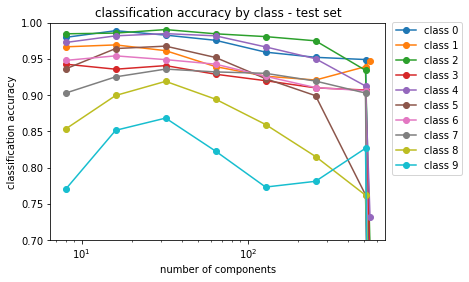

In [43]:
acctest = pickle.load(open(pca_path+'accuracies_testset.pkl','rb'))
nums = [8,16,32,64,128,256,512,545]
plt.title('classification accuracy by class - test set')
for ii in range(10):
  plt.semilogx(nums, acctest[:,ii], marker='o',label='class %d'%ii)
  plt.xlabel('number of components')
  plt.ylabel('classification accuracy')
  plt.legend(loc=(1.02,0.3))
  plt.ylim(0.7,1.)

No handles with labels found to put in legend.


0.9498731451903488


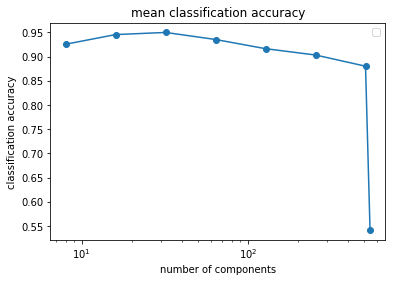

In [44]:
nums = [8,16,32,64,128,256,512,545]
plt.figure()
plt.title('mean classification accuracy')
plt.semilogx(nums, np.mean(acctest,axis=1), marker='o')
print(max(np.mean(acctest,axis=1)))
plt.xlabel('number of components')
plt.ylabel('classification accuracy')
plt.legend()
plt.show()

In [45]:
# do classification
nums = [8,16,32,64,128,256,512,545]
acc  = np.zeros((len(nums),10))


for ll in range(len(nums)):
  print(ll)
  num = nums[ll] 
  for ii in range(10):
    print(ii)
    indices = np.where(targets_train==ii)

    x_test_class =x_train[indices]
    logprob=[]
    for jj in range(10):
      pca, mask_1, mean = pickle.load(open(pca_path+'pca_on_%d_num_comp_full.pkl'%(jj),'rb')) 
      if num==-1:
        num = len(mask_1)-1
        print(num)
      cut_test  = x_test_class
      cut_test  = cut_test[:,mask_1]
      
      sing     = pca.explained_variance_[0:num]
      R        = pca.components_[0:num]
      
      if num<len(pca.explained_variance_):
        sigma2   = np.mean(pca.explained_variance_[num::])
      else:
        sigma2   = 0.
      
     
      
      C        = np.dot(R.T,np.dot(np.diag(sing), R))+np.eye(len(R.T))*sigma2
      sign ,logdetC = lg.slogdet(C)

        
      logprob+=[get_probability_of_data(logdetC,lg.inv(C),cut_test,mean)]
      

    correct = len(np.where(np.argsort(logprob, axis=0)[-1]==ii)[0])
    acc_ = np.float(correct)/np.float(len(x_test_class))
    print('acc:', acc_)
    acc[ll,ii]=acc_
    
pickle.dump(acc, open(pca_path+'accuracies_trainset.pkl','wb'))

0
0
acc: 0.9697891321978913
1
acc: 0.9540331102500881
2
acc: 0.9865136876006442
3
acc: 0.9219760831209567
4
acc: 0.9648075735748096
5
acc: 0.9425210830004439
6
acc: 0.943041809735407
7
acc: 0.9211594202898551
8
acc: 0.8296158612143743
9
acc: 0.7475942261427426
1
0
acc: 0.9742497972424979
1
acc: 0.9542092286016203
2
acc: 0.9897342995169082
3
acc: 0.9394236424230543
4
acc: 0.9796254373327845
5
acc: 0.9629383044829116
6
acc: 0.9523328620480711
7
acc: 0.933719806763285
8
acc: 0.8965303593556382
9
acc: 0.8203688853247795
2
0
acc: 0.9774939172749392
1
acc: 0.9503346248679112
2
acc: 0.9885265700483091
3
acc: 0.9455008821799648
4
acc: 0.9833299032722782
5
acc: 0.965601420328451
6
acc: 0.9547566148252878
7
acc: 0.9482125603864734
8
acc: 0.9258570838496489
9
acc: 0.8608660785886126
3
0
acc: 0.9720194647201946
1
acc: 0.9390630503698485
2
acc: 0.9905394524959742
3
acc: 0.9349147226034111
4
acc: 0.9781848116896481
5
acc: 0.96271637816245
6
acc: 0.9509190062613614
7
acc: 0.9509178743961353
8
acc: 0.

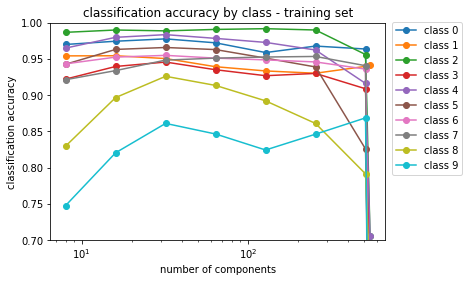

In [46]:
acctrain = pickle.load(open(pca_path+'accuracies_trainset.pkl','rb'))
nums = [8,16,32,64,128,256,512,545]
plt.title('classification accuracy by class - training set')
for ii in range(10):
  plt.semilogx(nums, acctrain[:,ii], marker='o',label='class %d'%ii)
  plt.xlabel('number of components')
  plt.ylabel('classification accuracy')
  plt.legend(loc=(1.02,0.3))
  plt.ylim(0.7,1.)

0.9498731451903488


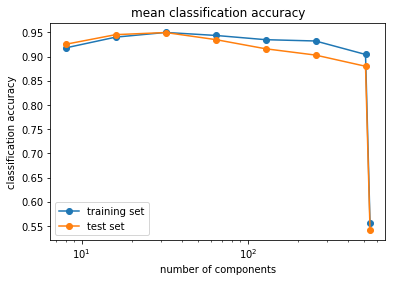

In [49]:
nums = [8,16,32,64,128,256,512,545]
plt.figure()
plt.title('mean classification accuracy')
plt.semilogx(nums, np.mean(acctrain,axis=1), marker='o',label='training set')
plt.semilogx(nums, np.mean(acctest,axis=1), marker='o', label='test set')
print(max(np.mean(acctest,axis=1)))
plt.xlabel('number of components')
plt.ylabel('classification accuracy')
plt.legend()
plt.show()

In [110]:
from sklearn.covariance import LedoitWolf, EmpiricalCovariance

for ii in range(10):
  indices       = np.where(targets_train==ii)
  x_train_class = x_train[indices]
  mask_1        = np.asarray(np.where(np.var(x_train_class, axis=0)>0.)[0])
  cut_train     = x_train_class[:,mask_1]
  cov           = LedoitWolf().fit(cut_train).covariance_
  #ov           = EmpiricalCovariance(assume_centered=False).fit(cut_train).covariance_
  mean          = np.mean(cut_train, axis=0)
  w,v           = np.linalg.eig(cov)
  indices       = np.argsort(w)[::-1]
  w=np.real(w[indices])
  vT=np.real(v.T[indices])
  vT = vT
  print(np.einsum('ji,j,jk->ik',vT,w,vT)/cov)
  pickle.dump([w,vT,mask_1,mean], open(pca_path+'cov_decomp_%d_shrunkLW.pkl'%ii,'wb'))

[[1.         1.0000012  0.9999992  ... 1.0000131  0.99998397 0.9999958 ]
 [1.0000011  0.99999994 0.99999917 ... 1.0000048  0.99998814 0.99999887]
 [0.9999992  0.99999917 1.         ... 0.9999983  0.9999796  0.9999591 ]
 ...
 [1.0000093  1.0000061  1.0000103  ... 0.99999976 1.0000001  0.9999998 ]
 [0.99999696 1.0000051  0.9999863  ... 1.0000001  1.0000002  1.0000002 ]
 [1.0000004  0.99998796 0.99997747 ... 0.99999964 1.0000001  0.9999998 ]]
[[1.0000001  1.0000002  1.0000001  ... 1.0000141  0.99999017 1.0000128 ]
 [1.0000002  1.0000002  0.99999994 ... 0.99998707 0.9999816  0.99998486]
 [1.0000001  1.         1.         ... 0.9999687  0.9999976  1.0000876 ]
 ...
 [1.0000051  0.9999964  0.9999298  ... 0.9999998  1.0000002  0.9999989 ]
 [0.99998045 0.99998724 1.0000049  ... 1.0000001  0.9999997  1.0000001 ]
 [1.0000037  0.9999942  1.0000488  ... 0.9999989  1.0000002  0.9999998 ]]
[[1.         1.000029   0.99996996 ... 0.9489773  1.0015746  0.99191904]
 [1.0000288  1.0000001  1.0000005  ... 

In [0]:
import numpy.linalg as lg
def get_probability_of_data(logdet,Cinv,data, mean):
  d    = len(data)
  data = data-mean

  Cinv_d = np.einsum('jk,...k->...j',Cinv,data, optimize=True)
#   plt.figure()
#   plt.imshow(Cinv_d[2].reshape(28,28))
#   plt.colorbar()
#   plt.show()
  
  logprob = -0.5*logdet-0.5*d*np.log((2*np.pi))-0.5*np.einsum('ij,ij->i',data, Cinv_d, optimize=True)
  logprob = logprob
  return logprob

In [112]:
# do classification
nums = [8,16,32,64,128,256,512,545]
acc  = np.zeros((len(nums),10))


for ll in range(len(nums)):
  print(ll)
  num = nums[ll] 
  for ii in range(10):
    print(ii)
    indices = np.where(targets_test==ii)

    x_test_class =x_test[indices]
    logprob=[]
    for jj in range(10):
      w,vT,mask_1,mean = pickle.load(open(pca_path+'cov_decomp_%d_shrunkLW.pkl'%jj,'rb'))
      
      if num==-1:
        num = len(mask_1)-1
        print(num)
      cut_test  = x_test_class
      cut_test  = cut_test[:,mask_1]
      
      sing     = w[0:num]
      vT       = vT[0:num]
      if num<len(w):
        sigma2   = np.mean(w[num::])
      else:
        sigma2   = 0.
      
     
      C = np.einsum('ji,j,jk->ik',vT,sing,vT,optimize=True)+np.eye(len(vT.T))*sigma2
      #print(C.shape)
      sign ,logdetC = lg.slogdet(C)

        
      logprob+=[get_probability_of_data(logdetC,lg.inv(C),cut_test,mean)]
      
    
    correct = len(np.where(np.argsort(logprob, axis=0)[-1]==ii)[0])
    acc_ = np.float(correct)/np.float(len(x_test_class))
    print('acc:', acc_)
    acc[ll,ii]=acc_
    
pickle.dump(acc, open(pca_path+'accuracies_LW_testset.pkl','wb'))

0
0
acc: 0.9795918367346939
1
acc: 0.9665198237885463
2
acc: 0.9844961240310077
3
acc: 0.9425742574257425
4
acc: 0.9725050916496945
5
acc: 0.9360986547085202
6
acc: 0.9478079331941545
7
acc: 0.9027237354085603
8
acc: 0.8531827515400411
9
acc: 0.7680872150644202
1
0
acc: 0.9887755102040816
1
acc: 0.9700440528634361
2
acc: 0.9854651162790697
3
acc: 0.9356435643564357
4
acc: 0.9816700610997964
5
acc: 0.9641255605381166
6
acc: 0.954070981210856
7
acc: 0.9260700389105059
8
acc: 0.8963039014373717
9
acc: 0.8513379583746283
2
0
acc: 0.9826530612244898
1
acc: 0.9621145374449339
2
acc: 0.9903100775193798
3
acc: 0.9415841584158415
4
acc: 0.984725050916497
5
acc: 0.9674887892376681
6
acc: 0.9488517745302714
7
acc: 0.9357976653696498
8
acc: 0.9168377823408624
9
acc: 0.867195242814668
3
0
acc: 0.976530612244898
1
acc: 0.9427312775330396
2
acc: 0.9854651162790697
3
acc: 0.9277227722772278
4
acc: 0.9816700610997964
5
acc: 0.9517937219730942
6
acc: 0.94258872651357
7
acc: 0.9319066147859922
8
acc: 0.8

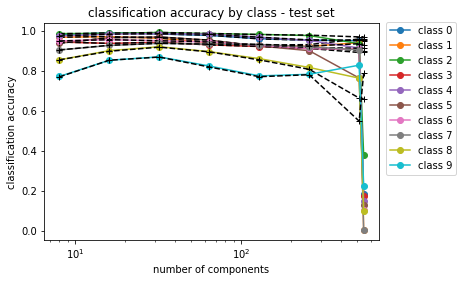

In [123]:
acctest = pickle.load(open(pca_path+'accuracies_covesti_testset.pkl','rb'))
acctest2 = pickle.load(open(pca_path+'accuracies_LW_testset.pkl','rb'))
nums = [8,16,32,64,128,256,512,545]
plt.title('classification accuracy by class - test set')
for ii in range(10):
  p= plt.semilogx(nums, acctest[:,ii], marker='o',label='class %d'%ii)
  plt.semilogx(nums, acctest2[:,ii], c='black', ls = '--',marker='+')#,label='class %d'%ii)
  plt.xlabel('number of components')
  plt.ylabel('classification accuracy')
  plt.legend(loc=(1.02,0.3))
  #plt.ylim(0.7,1.)

In [0]:
# do classification
nums = [10,30,60,100,300,500]
# do classification
acc = np.zeros((len(nums),10))


for ll in range(len(nums)):
  num = nums[ll] 
  print(num, ll)
  for ii in range(10):
    print(ii)
    indices = np.where(targets_train==ii)
    x_test_class =x_train[indices]
    logprob=[]
    for jj in range(10):
      pca, mask_0, mask_1, mean = pickle.load(open(pca_path+'pca_on_%d_num_comp_full_inpainted.pkl'%(jj),'rb')) 
      
      inpaint   = np.random.randn(len(mask_0)*len(x_test_class))*0.01
      cut_test  = x_test_class
      cut_test[:,mask_0] = inpaint.reshape((len(x_test_class),len(mask_0)))
      
      sing     = pca.singular_values_[0:num]
      R        = pca.components_[0:num]

      sigma2   = np.mean(pca.explained_variance_[num::])
      
      C_       = np.zeros((28*28,28*28))
      mean_d   = np.zeros((28*28))
      
      C_pca    = np.dot(R.T,np.dot(np.diag(sing), R))
      
      kk = 0
      for nn in range(28*28):
        if nn in mask_1:
          C_[nn,mask_1] = C_pca[kk]
          mean_d[nn] = mean[kk]
          kk+=1
        if nn in mask_0:
          C_[nn:nn] = 0.1
          
      C_ = C_+np.eye(len(C_))*sigma2
      
#       plt.figure()
#       plt.imshow(np.diag(C_).reshape((28,28)))
#       plt.colorbar()
#       plt.show()
      
#       plt.figure()
#       plt.imshow(mean_d.reshape((28,28)))
#       plt.colorbar()
#       plt.show()
      
      #print(min(np.diag(C_)))
      sign ,logdetC = lg.slogdet(C_)
      logprob+=[get_probability_of_data(logdetC,lg.inv(C_),cut_test,mean_d)]
      

    correct = len(np.where(np.argsort(logprob, axis=0)[-1]==ii)[0])
    acc_ = np.float(correct)/np.float(len(x_test_class))
    print('acc:', acc_)
    acc[ll,ii]=acc_
    
pickle.dump(acc, open(pca_path+'accuracies_addedvariance_trainset.pkl','wb'))

10 0
0
acc: 0.981346309813463
1
acc: 0.9695315251849242
2
acc: 0.9446457326892109
3
acc: 0.9206038031758479
4
acc: 0.960279892982095
5
acc: 0.9349755881047492
6
acc: 0.9701070490809938
7
acc: 0.9352657004830918
8
acc: 0.9196612969847171
9
acc: 0.921411387329591
30 1
0
acc: 0.9894566098945661
1
acc: 0.9672419866150053
2
acc: 0.961755233494364
3
acc: 0.9378553224857871
4
acc: 0.9643959662481992
5
acc: 0.9462938304482912
6
acc: 0.9707129872752979
7
acc: 0.9466666666666667
8
acc: 0.9568360181743082
9
acc: 0.9504811547714515
60 2
0
acc: 0.9860097323600974
1
acc: 0.9584360690383938
2
acc: 0.9557165861513688
3
acc: 0.9335424426583023
4
acc: 0.9573986416958222
5
acc: 0.9380825565912118
6
acc: 0.9686931932942839
7
acc: 0.9321739130434783
8
acc: 0.9454770755885997
9
acc: 0.9434643143544507
100 3
0
acc: 0.9835766423357665
1
acc: 0.9566748855230714
2
acc: 0.9430354267310789
3
acc: 0.9125661634973534
4
acc: 0.9471084585305618
5
acc: 0.9207723035952063
6
acc: 0.9656635023227631
7
acc: 0.907439613526